In [739]:
import numpy as np
import pandas as pd
import re
import difflib
import seaborn as sns
import math
import matplotlib.pyplot as plt 
%matplotlib inline
from math import factorial

In [740]:
!pwd

/Users/jaichitra.balakrishnan/galvanizeu/DSCI6002-student/Project


**Read Data**

In [741]:
menu     = pd.read_csv("../data/whats-on-the-menu/Menu.csv")

In [742]:
menuitem = pd.read_csv("../data/whats-on-the-menu/MenuItem.csv")

In [743]:
menupage = pd.read_csv("../data/whats-on-the-menu/MenuPage.csv")

In [744]:
dish     = pd.read_csv("../data/whats-on-the-menu/Dish.csv")

**Data Health Check and Prepare Clean Data Set for Analysis**

In [745]:
# Overview menu
print(menu.shape)
print(menu.columns)
menu.head(n=5)

(17545, 20)
Index(['id', 'name', 'sponsor', 'event', 'venue', 'place',
       'physical_description', 'occasion', 'notes', 'call_number', 'keywords',
       'language', 'date', 'location', 'location_type', 'currency',
       'currency_symbol', 'status', 'page_count', 'dish_count'],
      dtype='object')


,id,name,sponsor,event,venue,place,physical_description,occasion,notes,call_number,keywords,language,date,location,location_type,currency,currency_symbol,status,page_count,dish_count
0,12463,NaN,HOTEL EASTMAN,BREAKFAST,COMMERCIAL,"HOT SPRINGS, AR",CARD; 4.75X7.5;,EASTER;,NaN,1900-2822,NaN,NaN,1900-04-15,Hotel Eastman,NaN,NaN,NaN,complete,2,67
1,12464,NaN,REPUBLICAN HOUSE,[DINNER],COMMERCIAL,"MILWAUKEE, [WI];",CARD; ILLUS; COL; 7.0X9.0;,EASTER;,WEDGEWOOD BLUE CARD; WHITE EMBOSSED GREEK KEY ...,1900-2825,NaN,NaN,1900-04-15,Republican House,NaN,NaN,NaN,complete,2,34
2,12465,NaN,NORDDEUTSCHER LLOYD BREMEN,FRUHSTUCK/BREAKFAST;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, STEAMSHIP A...",1900-2827,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,84
3,12466,NaN,NORDDEUTSCHER LLOYD BREMEN,LUNCH;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2828,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,63
4,12467,NaN,NORDDEUTSCHER LLOYD BREMEN,DINNER;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,FOLDER; ILLU; COL; 5.5X7.5;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2829,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,4,33


In [746]:
# Check if id can be used as unique identifier in menu
print(menu['id'].isnull().sum(), menu.duplicated(['id']).sum())

0 0


In [747]:
# Check which of name, sponsor, place, location are 'cleaner' to describe location of menu
print("Name nulls     - ", menu.name.isnull().sum())
print("Sponsor nulls  - ", menu.sponsor.isnull().sum())
print("Place nulls    - ", menu.place.isnull().sum())
print("Location nulls - ", menu.location.isnull().sum())

Name nulls     -  14348
Sponsor nulls  -  1561
Place nulls    -  9422
Location nulls -  0


In [748]:
# Copy relevant fields to new df
mdf = menu[['id', 'event', 'venue', 'occasion', 'date', 'location', 'status', 'dish_count']]

In [749]:
# Split date to year, month and day columns
# Avoid loc warning about writes making it back to the original frame 
pd.options.mode.chained_assignment = None
mdf['year'], mdf['month'], mdf['day'] = mdf['date'].str.split('-', 2).str

In [750]:
# Make to string, lower case and remove special characters
mdf = mdf.apply(lambda x: x.astype(str).str.lower())
mdf = mdf.apply(lambda x: x.replace('[^A-Za-z0-9]',' ',regex=True))
mdf = mdf.apply(lambda x: x.str.strip())
del mdf['date']

In [751]:
# Find max and min values for year
print("Year  -", sorted(mdf.year.unique())[0:5], sorted(mdf.year.unique())[-5:])
print("Month -", sorted(mdf.month.unique())[0:5], sorted(mdf.month.unique())[-5:])
print("Day   -", sorted(mdf.day.unique())[0:5], sorted(mdf.day.unique())[-5:])

Year  - ['0001', '0190', '1091', '1851', '1852'] ['2008', '2012', '2015', '2928', 'nan']
Month - ['01', '02', '03', '04', '05'] ['09', '10', '11', '12', 'nan']
Day   - ['01', '02', '03', '04', '05'] ['28', '29', '30', '31', 'nan']


In [752]:
# Find if dates are relatable and find count to decided if observations can be dropped
print("Year nulls  - ", len(mdf[mdf.year=='nan']))
print("Month nulls - ", len(mdf[mdf.month=='nan']))
print("Day nulls   - ", len(mdf[mdf.day=='nan']))

Year nulls  -  586
Month nulls -  586
Day nulls   -  586


In [753]:
mdf[((mdf['year'] < '1800') & (mdf['year'] > '2017'))].shape

(0, 10)

In [754]:
# Hardly any records to affect if incorrect guess
mdf.loc[mdf['year'] =='0190', 'year'] = '1990'
mdf.loc[mdf['year'] =='1091', 'year'] = '1991'
mdf.loc[mdf['year'] =='2928', 'year'] = '1928'
mdf.loc[mdf['year'] =='0001', 'year'] = '2001'

In [755]:
mdf[((mdf['year'] > '1800') & (mdf['year'] <= '2017')) & \
          ((mdf['month'] >= '01') & (mdf['month'] <= '12')) & \
          ((mdf['day'] >= '01') & (mdf['day'] <= '31')) ].shape

(16959, 10)

In [756]:
# Leave out the records with null values. Enough data to work with
mdf = mdf[((mdf['year'] > '1800') & (mdf['year'] <= '2017')) & \
          ((mdf['month'] >= '01') & (mdf['month'] <= '12')) & \
          ((mdf['day'] >= '01') & (mdf['day'] <= '31')) ]

In [757]:
mdf["id"] = mdf.id.apply(int)
mdf["dish_count"] = mdf.dish_count.apply(int)
mdf["year"] = mdf.year.apply(int)
mdf["month"] = mdf.month.apply(int)
mdf["day"] = mdf.day.apply(int)

In [758]:
# See if the Status categorical feature has limited values
print('Unique Status Values   # -',len(mdf.status.unique()))
print('Unique Status Values     -',mdf.status.unique())

Unique Status Values   # - 2
Unique Status Values     - ['complete' 'under review']


In [759]:
# See if the Event categorical feature has limited values
print('Unique Event Values   # -',len(mdf.event.unique()))
print('Unique Event Values     -',mdf.event.unique()[0:50])

Unique Event Values   # - 1649
Unique Event Values     - ['breakfast' 'dinner' 'fruhstuck breakfast' 'lunch' 'supper'
 'cafe luncheon' 'annual banquet' 'dinne' 'nan' 'luncheon' 'carte du jour'
 'annual meeting' 'banquet of the fifty ninth annual convention'
 'fifth annual reunion' 'shakepeare commemoration'
 '26th anniversary banquet' 'twenty ninth annual dinner' 'sunday dinner'
 'second annual dinner' 'seventh annual dinner' 'lunch   dinner'
 'annual dinner'
 'complimentary banquet given by the city government of boston to the boards of trade of the western cities'
 'fest bankett' 'daily menu' 'daily menu   11 30 to 3 00'
 'dinner to the board of officers of the catholic club of the city of new york'
 'annual outing of edward thompson co' 'banquet' 'menu'
 'semi annual dinner' 'souper' '11th annual banquet'
 'daily menu   11 30 t0 3 00' 'a la carte menu' 'tiffin' 'annual outing'
 'evening dinner' 'dinner in honor of h i m mutsu hito 47th birthday'
 'evening meal' 'daily' 'bill of fare

In [760]:
mdf.head(n=10)

,id,event,venue,occasion,location,status,dish_count,year,month,day
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16
5,12468,dinner,commercial,nan,canadian pacific railway company,complete,37,1900,4,16
6,12469,supper,commercial,nan,hotel netherland,complete,144,1900,4,16
7,12470,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,80,1900,4,17
8,12471,lunch,commercial,nan,norddeutscher lloyd bremen,complete,67,1900,4,17
9,12472,dinner,commercial,nan,norddeutscher lloyd bremen,complete,29,1900,4,17


In [761]:
# Make approximate event type from event
# Check type of source field. As the object had both float and string elements
mdf.event.map(lambda x: type(x))
# Cast elements of the event object as str and make eventt
mdf['eventt'] = mdf.event.apply(str)

def set_eventt(lval):
    for idx in range(len(lval)):
        val = [x.replace("_"," ") for x in str.split(lval[idx],":")]
        # If close match found, then replace with last ordered, matched lval else miscellaneous
        mdf.eventt = mdf.eventt.apply(lambda txt: (val[len(val)-1]) \
                 if len(difflib.get_close_matches(val[len(val)-2], txt.split())) \
                 else txt)
        #mdf.loc[mdf['eventt'].str.contains(, case=False), 'eventt'] = val[len(val)-1]

#List of possible event values with search and replace string seperated by : if different
events = "lunch breakfast dinner morning:breakfast afternoon:lunch supper:dinner \
          menu annual:organized meeting:organized banquet:organized convention:organized \
          reunion:organized \
          christmas:holiday new_year:holiday patrick:holiday july:holiday \
          thanksgiving:holiday veterans:holiday day:holiday \
          anniversary:celebration birthday:celebration wedding:celebration".split()
set_eventt(events)
allowed_events=[x.split(':')[-1].replace("_"," ") for x in events]
mdf.loc[~mdf["eventt"].isin(allowed_events), "eventt"] = "miscellaneous"

In [762]:
# See if the approximated Eventt categorical feature has limited values
print('Unique Eventt Values   # -',len(mdf.eventt.unique()))
print('Unique Eventt Values     -',mdf.eventt.unique())

Unique Eventt Values   # - 8
Unique Eventt Values     - ['breakfast' 'dinner' 'lunch' 'organized' 'miscellaneous' 'menu' 'holiday'
 'celebration']


In [763]:
print('Unique Venue Values    # -',len(mdf.venue.unique()))
print('Unique Occasion Values # -',len(mdf.occasion.unique()))

Unique Venue Values    # - 141
Unique Occasion Values # - 320


In [764]:
type(mdf.year.map(lambda x: int(round(x/10,2)*10)))

pandas.core.series.Series

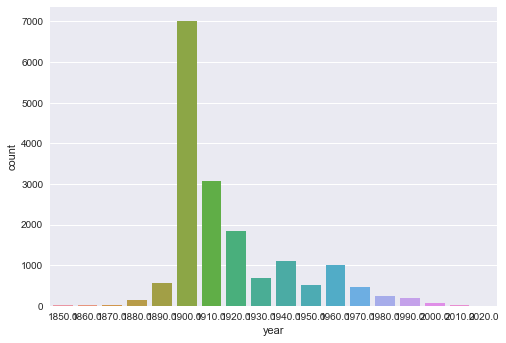

In [765]:
sns.set(style="darkgrid")
ax = sns.countplot(x=(round(mdf.year/10,0)*10), data=mdf)

The menus are from 1851 to 2017. However many of the menus are from the turn of the 20th century. Very few of the menus are from this century. This could be a reflection of a change in the food culture between 1900-1920. Or, it may just ne that modern menus are not yet fully included and represented in the data set

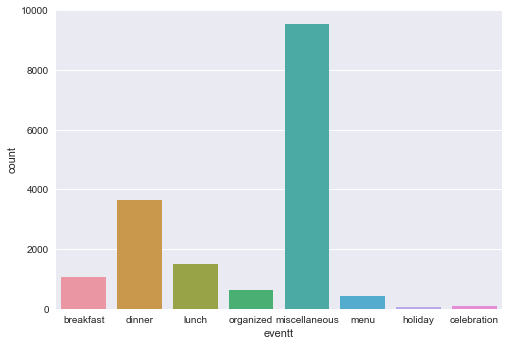

In [766]:
sns.set(style="darkgrid")
ax = sns.countplot(x=mdf.eventt, data=mdf)

In [767]:
pd.crosstab(mdf.eventt, mdf.status, margins=True)

status,complete,under review,All
eventt,,,
breakfast,1067,2,1069
celebration,81,0,81
dinner,3621,13,3634
holiday,68,0,68
lunch,1506,2,1508
menu,431,1,432
miscellaneous,9500,40,9540
organized,625,2,627
All,16899,60,16959


Crosstab of the menu status tells us most menus are complete and very few are under review in the system

In [768]:
sorted(mdf.venue.unique())
#mdf.loc[mdf["occasion"].isin(['gov','govt']), "eventt"] = "miscellaneous"

['',
 'aa',
 'airline',
 'alumni',
 'cam',
 'club',
 'cmmercial',
 'com',
 'com  pol',
 'com soc',
 'comm',
 'commercial',
 'commercoa',
 'conn',
 'cultural',
 'dom',
 'educ',
 'educ  prof',
 'educational',
 'edus',
 'foreign',
 'foreign  hotel',
 'foreign hotel',
 'foreign hotel restaurant',
 'foreign restaurant',
 'foreigneign',
 'fraternity',
 'gk',
 'gov',
 'gov t',
 'govt',
 'greek letter  fraternity or sorority',
 'hotel',
 'hotel  for',
 'hotel restaurant',
 'individual',
 'mil',
 'milit',
 'military',
 'musical',
 'nac',
 'nan',
 'nav',
 'naval',
 'other',
 'other   presumably british royal family',
 'other  appears to be a private luncheon party',
 'other  british royal family',
 'other  club',
 'other  expatriate',
 'other  group of citizens',
 'other  group of friends',
 'other  head of royal family',
 'other  hospital',
 'other  individual',
 'other  individually hosted party',
 'other  international cultural group',
 'other  literary assoc',
 'other  london club',
 'other 

In [769]:
mdf["occasion_type"] = mdf.venue
mdf.loc[mdf['occasion_type'].str.contains('other'), 'occasion_type']= 'other'
mdf.loc[mdf['occasion_type'].str.contains('airline'), 'occasion_type'] = 'airline'
mdf.loc[mdf['occasion_type'].str.contains('aa'), 'occasion_type'] = 'airline'
mdf.loc[mdf['occasion_type'].str.contains('cam'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('cmmercial'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('com'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('conn'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('club'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('dom'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('edu'), 'occasion_type'] = 'educational'
mdf.loc[mdf['occasion_type'].str.contains('foreign'), 'occasion_type'] = 'foreign'
mdf.loc[mdf['occasion_type'].str.contains('fraternity'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('gk'), 'occasion_type'] = 'government'
mdf.loc[mdf['occasion_type'].str.contains('gov'), 'occasion_type'] = 'government'
mdf.loc[mdf['occasion_type'].str.contains('hotel'), 'occasion_type'] = 'restauarant'
mdf.loc[mdf['occasion_type'].str.contains('individual'), 'occasion_type'] = 'individual'
mdf.loc[mdf['occasion_type'].str.contains('mil'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('nac'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('nav'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('museum'), 'occasion_type'] = 'entertainment'
mdf.loc[mdf['occasion_type'].str.contains('music'), 'occasion_type'] = 'entertainment'
mdf.loc[mdf['occasion_type'].str.contains('nan'), 'occasion_type'] = 'unknown'
mdf.loc[mdf['occasion_type'].str.contains('res'), 'occasion_type'] = 'restauarant'
mdf.loc[mdf['occasion_type'].str.contains('rel'), 'occasion_type'] = 'religious'
mdf.loc[mdf['occasion_type'].str.contains('soc'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('som'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('ss'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('pol'), 'occasion_type'] = 'political'
mdf.loc[mdf['occasion_type'].str.contains('pat'), 'occasion_type'] = 'patriotic'
mdf.loc[mdf['occasion_type'].str.contains('pri'), 'occasion_type'] = 'private'
mdf.loc[mdf['occasion_type'].str.contains('pro'), 'occasion_type'] = 'professional'
mdf.loc[mdf['occasion_type'].str.contains('reporters'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('steamship'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains(''), 'occasion_type'] = 'unknown'
mdf.loc[mdf['occasion_type'].str.contains('nan'), 'occasion_type'] = 'unknown'



In [770]:
#def similar(a, b):
#    return SequenceMatcher(None, a, b).ratio()

_MenuItem File_

In [771]:
# Subset relevant data
menuitem.head(n=5)
midf = menuitem[['id', 'menu_page_id', 'price', 'dish_id']]

In [772]:
df = pd.merge(mdf, midf, on=['id'], how = 'left')
df.head(n=5)

,id,event,venue,occasion,location,status,dish_count,year,month,day,eventt,occasion_type,menu_page_id,price,dish_id
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15,breakfast,unknown,4129.0,0.1,2479.0
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15,dinner,unknown,4895.0,NaN,7293.0
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16,breakfast,unknown,5171.0,0.5,7294.0
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16,lunch,unknown,4895.0,NaN,7295.0
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16,dinner,unknown,4895.0,NaN,7296.0


In [773]:
# Replace missing values for dish id by the year's mode
df['dish_id'] = df.groupby(["year"]).dish_id.transform(lambda x: x.fillna(x.value_counts().index[0]))

In [774]:
# Replace missing values for price by the year and location's mean
df['price'] = df.groupby(["year","location"]).price.transform(lambda x: x.fillna(x.mean()))

In [775]:
# Replace missing values for price by the year's mean
df['price'] = df.groupby(["eventt"]).price.transform(lambda x: x.fillna(x.mean()))

In [588]:
#df.loc[df.price > 1, 'price'] = round(df.price,0)-df.price

In [776]:
#df.loc[df.price < 1, 'price'] = abs(df.price)

In [777]:
df.price.max()

100.0

In [778]:
df[df.price.isnull()]

,id,event,venue,occasion,location,status,dish_count,year,month,day,eventt,occasion_type,menu_page_id,price,dish_id


In [779]:
df[df.location == 'alpha of zeta psi']

,id,event,venue,occasion,location,status,dish_count,year,month,day,eventt,occasion_type,menu_page_id,price,dish_id
11,12474,annual banquet,commercial,nan,alpha of zeta psi,complete,38,1900,4,17,organized,unknown,4895.0,0.944748,7300.0


In [780]:
# Make id and dish id to int fields
df["id"] = df.id.apply(int)
#df["menu_page_id"] = df.menu_page_id.apply(int)
df["dish_id"] = df.dish_id.apply(int)
df["price"] = df.price.apply(int)

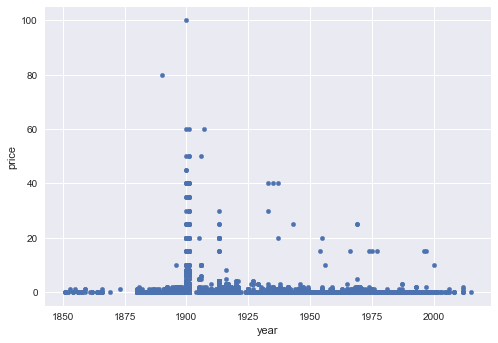

In [781]:
df.plot(kind='scatter',
         x='year',
         y='price');

There is an upward trend to the price but its correlation to year if any is not apparent at this stage

4053 0


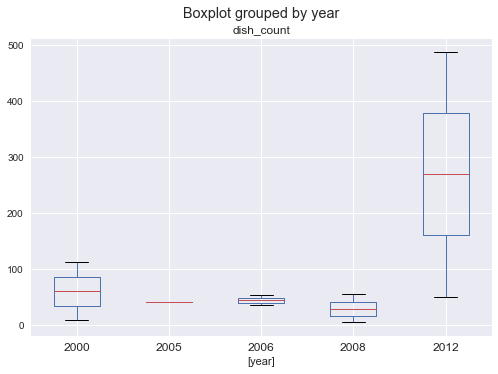

In [782]:
# Distribution of menu fish counts
print(df.dish_count.max(), df.dish_count.min())
df[(df.year >= 2000) & ((df.eventt =='lunch') | (df.eventt =='dinner') | (df.event == 'breakfast'))][["year", "dish_count", "eventt"]].boxplot(by = "year")

There are not many outliers in the dish count in each year. And, there seems to be a generakl upward trend with highest concentration in the 50% percentile

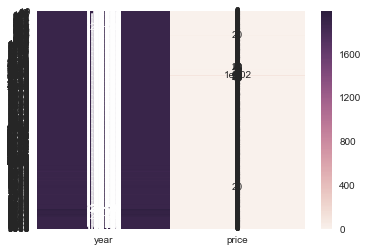

In [783]:
import seaborn as sns
%matplotlib inline

sns.heatmap(df[df.event=="breakfast"][["year", "price"]], annot=True)

In [784]:
df.head(n=10)

,id,event,venue,occasion,location,status,dish_count,year,month,day,eventt,occasion_type,menu_page_id,price,dish_id
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15,breakfast,unknown,4129.0,0,2479
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15,dinner,unknown,4895.0,0,7293
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16,breakfast,unknown,5171.0,0,7294
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16,lunch,unknown,4895.0,0,7295
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16,dinner,unknown,4895.0,0,7296
5,12468,dinner,commercial,nan,canadian pacific railway company,complete,37,1900,4,16,dinner,unknown,4129.0,0,2474
6,12469,supper,commercial,nan,hotel netherland,complete,144,1900,4,16,dinner,unknown,910.0,0,7305
7,12470,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,80,1900,4,17,breakfast,unknown,4895.0,0,7297
8,12471,lunch,commercial,nan,norddeutscher lloyd bremen,complete,67,1900,4,17,lunch,unknown,5171.0,0,77083
9,12472,dinner,commercial,nan,norddeutscher lloyd bremen,complete,29,1900,4,17,dinner,unknown,5171.0,0,232


_Dish File_

In [785]:
# Subset relevant data
dish.head(n=5)
ddf = dish
ddf.drop('description', axis=1)

,id,name,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
0,1,Consomme printaniere royal,8,9,1897,1927,0.20,0.40
1,2,Chicken gumbo,110,116,1895,1960,0.10,0.80
2,3,Tomato aux croutons,13,13,1893,1917,0.25,0.40
3,4,Onion au gratin,41,41,1900,1971,0.25,1.00
4,5,St. Emilion,66,68,1881,1981,0.00,18.00
5,7,Radishes,3265,3349,1854,2928,0.00,25.00
6,8,Chicken soup with rice,48,49,1897,1961,0.10,0.60
7,9,Clam broth (cup),15,17,1899,1962,0.15,0.40
8,10,"Cream of new asparagus, croutons",2,2,1900,1900,0.00,0.00
9,11,Clear green turtle,157,157,1893,1937,0.25,60.00


In [786]:
df = pd.merge(df, ddf, left_on=['dish_id'], right_on=['id'], how = 'left')
df.head(n=5)

,id_x,event,venue,occasion,location,status,dish_count,year,month,day,...,dish_id,id_y,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15,...,2479,2479,Custard Pie,NaN,295,301,1866,1955,0.05,15.0
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15,...,7293,7293,"Cream of Artichokes, Jerusalem",NaN,2,2,1906,1906,0.00,0.0
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16,...,7294,7294,"Assort. Cold Meat, Wanamaker Salad",NaN,2,2,1906,1906,0.50,0.5
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16,...,7295,7295,French Pot-au-feu,NaN,2,2,1906,1906,0.00,0.0
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16,...,7296,7296,Santa Claus Ice Cream,NaN,2,2,1906,1906,0.00,0.0


**Some Probabilities**

1) Given equal opportunity of going to Norddeutscher Lloyd Bremen, probability that it was a breakfast event is :

In [787]:
event = len(df[(df.location == "norddeutscher lloyd bremen") & (df.eventt == 'breakfast')])
space = len(df[df.location == "norddeutscher lloyd bremen"])
print("Event :", event, "   Space:", space, "   Probability = ", event_occurs / space )

Event : 126    Space: 688    Probability =  0.18313953488372092


In [788]:
df[(df.year > 2001)]

,id_x,event,venue,occasion,location,status,dish_count,year,month,day,...,dish_id,id_y,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
4593,20962,dinner,restaurant,nan,diner restaurant,complete,41,2005,1,1,...,155,155,Oatmeal,NaN,532,610,1,1988,0.00,20.00
4594,20966,dinner,restaurant,nan,the modern,complete,29,2008,3,3,...,1311,1311,Neufchatel,NaN,430,489,1882,1963,0.10,30.00
6353,23157,dinner,other loft apartment,nan,whisk ladle supper club,complete,5,2008,1,1,...,2767,2767,"Potatoes, lyonnaise",NaN,219,225,1889,1959,0.00,20.00
6481,23314,chef s tasting menu,restaurant,nan,per se,complete,31,2006,1,1,...,103,103,Kippered Herring,NaN,231,236,1,1970,0.00,0.85
6540,23385,lunch menu,restaurant,nan,spotted pig,complete,35,2006,1,1,...,1815,1815,Broiled Kidneys,NaN,40,41,1858,1913,0.25,0.60
8300,25602,breakfast lunch and dinner,restaurant,nan,balthazar,complete,54,2006,1,1,...,200,200,Chow chow,NaN,675,686,1865,1965,0.00,20.00
8945,26448,nan,restaurant,nan,krogs fiskerestaurant,complete,104,2015,4,20,...,67,67,Oranges,NaN,1423,1479,1851,2012,0.00,25.00
9010,26652,nan,nan,nan,palio,complete,144,2012,4,26,...,4949,4949,"Steak, Sirloin, extra with Onions",NaN,2,2,1901,1901,0.00,0.00
9018,26680,nan,restaurant,nan,zum durnbrau,complete,210,2005,1,14,...,1616,1616,Peach Pie,NaN,517,558,1854,1980,0.00,15.00
9027,26698,dinner and wine and birthday,restaurant,nan,benoit,complete,55,2008,5,20,...,13134,13134,Broiled Kidney and Bacon,NaN,6,6,1900,1901,0.25,0.25


2) Given that the choice of days and meals are all equally likely and that a meal cant be repeated,  probability that all 3 meals a person went to between 1900 and 1901 at Norddeutscher Lloyd Bremen were all breakfast is :

In [789]:
space = len(df[(df.location == "norddeutscher lloyd bremen") & ((df.year == 1900) | (df.year == 1901))])
event = len(df[(df.location == "norddeutscher lloyd bremen") & (df.eventt == 'breakfast') & ((df.year == 1900) | (df.year == 1901))])
print("Space-",space,"Event-", event)

Space- 478 Event- 72


In [790]:
def choose(n, c):
    "Number of ways to choose c items from a list of n items."
    return factorial(n) / (factorial(n - c) * factorial(c))

In [791]:
choose(72,3) / choose(478, 3)

0.0032971268557948166

3) Bayes Theorem Application. Find probability that tyhe meal was not breakfast given that it was at a place other than NLL and the following priors and posterior

In [792]:
space = len(df[(df.year == 1900)])

event_a = len(df[(df.location == "norddeutscher lloyd bremen") & (df.year == 1900)])
print("Probability eating at NLL in 1900", round(event_a/space,2))

event_b = len(df[(df.eventt == "breakfast") & (df.year == 1900)])
print("Probability eating  breakfast in 1900", round(event_b/space,2))

event_c = len(df[(df.location != "norddeutscher lloyd bremen") & (df.eventt != "breakfast")& (df.year == 1900)])
print("Probability eating at a place other than NLL given it was not breakfast in 1900", round(event_c/space,2))

event_d = len(df[(df.location == "norddeutscher lloyd bremen") & (df.eventt == "breakfast")& (df.year == 1900)])
print("Probability eating at NLL a breakfast in 1900", round(event_d/space,4))

event_e = len(df[(df.eventt != "breakfast")& (df.year == 1900)])
print("Probability not eating a breakfast in 1900", round(event_e/space,4))



Probability eating at NLL in 1900 0.01
Probability eating  breakfast in 1900 0.15
Probability eating at a place other than NLL given it was not breakfast in 1900 0.84
Probability eating at NLL a breakfast in 1900 0.0027
Probability not eating a breakfast in 1900 0.8536


|                | Breakfast | Not Breakfast |
|----------------|------------:|-------------------:|
| Eat at NLL |        0.03 |               0.26 |
| Eat other than at NLL |        0.07 |               0.84 |

\begin{align*}
P(\text{not breakfast } | \text{ not in NLL}) 
&= \frac{P(\text{not in NLL } | \text{ not breakfast})P(\text{not breakfast})}{P(\text{not in NLL})}
\\
&= \frac{0.84*0.85}{0.85*.84 + ((1-0.85)*0.26)}
\\
&\approx 0.94
\end{align*}

In [793]:
(0.84*0.85) / ((0.85 * 0.84) + ((1-0.85)*(0.26)))

0.948207171314741

** Discrete Probability Distribution **

In [794]:
p_b = len(df[(df.eventt == "breakfast")])/len(df)
p_c = len(df[(df.eventt == "celebration")])/len(df)
p_d = len(df[(df.eventt == "dinner")])/len(df)
p_h = len(df[(df.eventt == "holiday")])/len(df)
p_l = len(df[(df.eventt == "lunch")])/len(df)
p_m = len(df[(df.eventt == "menu")])/len(df)
p_mi = len(df[(df.eventt == "miscellaneous")])/len(df)
p_o = len(df[(df.eventt == "organized")])/len(df)

#print("Probability of going out for breakfast before the year 20000", round(event/space,2))

In [795]:
multser=df.groupby("eventt").size()
multser

eventt
breakfast        1069
celebration        81
dinner           3634
holiday            68
lunch            1508
menu              432
miscellaneous    9540
organized         627
dtype: int64

In [796]:
multdf = pd.DataFrame({'eventt':multser.index, 'frequency':multser.values})


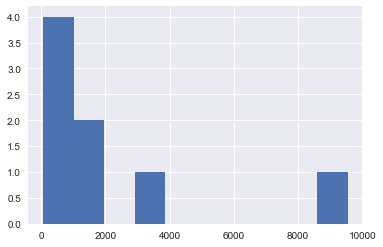

In [797]:
plt.hist(multdf.frequency)
plt.show()

In [798]:
dir(scipy.stats)
import numpy as np
X = np.random.randint(8, size=(8, 3))
print(X)
y = np.array([0, 1, 2, 3, 4, 5, 6, 7])
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
print(clf.predict(X[5:8]))
print(clf.predict_proba(X[5:8]))

[[5 4 6]
 [4 6 6]
 [1 5 2]
 [3 3 4]
 [6 3 4]
 [4 6 3]
 [2 7 0]
 [0 7 5]]
[5 6 7]
[[ 0.09543043  0.17158364  0.16703083  0.12381027  0.0780931   0.29895014
   0.05677786  0.00832372]
 [ 0.00308141  0.01386609  0.10320355  0.00537229  0.0025389   0.06511132
   0.79497096  0.01185547]
 [ 0.007078    0.03899722  0.13516156  0.01370409  0.00113431  0.01868301
   0.00146675  0.78377507]]


**Continuous Probability Distribution**

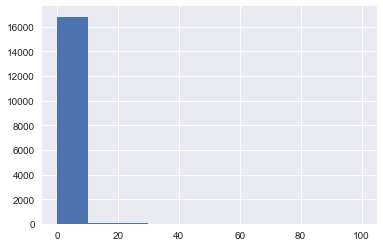

In [799]:
pricedf = df.price
pricedf.hist();

In [800]:
from scipy.stats import norm
μ, σ = norm.fit(pricedf)
print(μ)
print(σ)

0.363287929713
2.5149448118


In [801]:
import matplotlib.pyplot as plt
import numpy as np

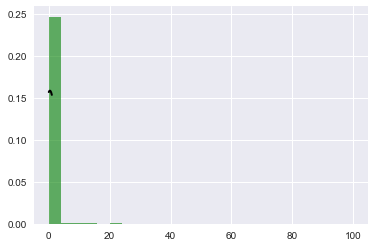

In [802]:
plt.hist(pricedf, bins=25, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(0, 1, 500)
p = norm.pdf(x, μ, σ)
plt.plot(x, p, 'k', linewidth=2);
title = "Fit results: mu = {:.2f},  std = {:.2f}".format(μ, σ)


Definitely NOT NORMAL

In [805]:
from scipy.stats import beta

In [806]:
pricedf.max(), pricedf.min()

(100, 0)

In [807]:
a, b, loc, scale = scipy.stats.beta.fit(pricedf, loc=0)
print(a, b, loc, scale)

/Users/jaichitra.balakrishnan/anaconda3/envs/stats/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
/Users/jaichitra.balakrishnan/anaconda3/envs/stats/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.161606773159 502.524907504 -4.87340249207e-29 344.047541242


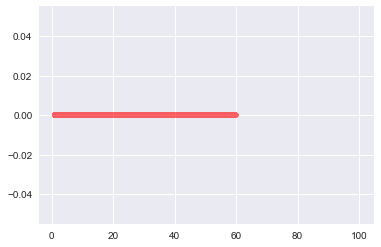

In [808]:
plt.plot(pricedf, beta.pdf(pricedf, a, b),'r-', lw=5, alpha=0.6, label='beta pdf');

In [809]:
fitted_beta = scipy.stats.beta(a, b)
fitted_beta_y = fitted_beta.pdf(pricedf)

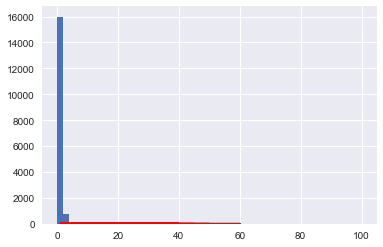

In [810]:
plt.hist(pricedf, bins=50)
plt.plot(pricedf, fitted_beta_y, 'r');

In [811]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

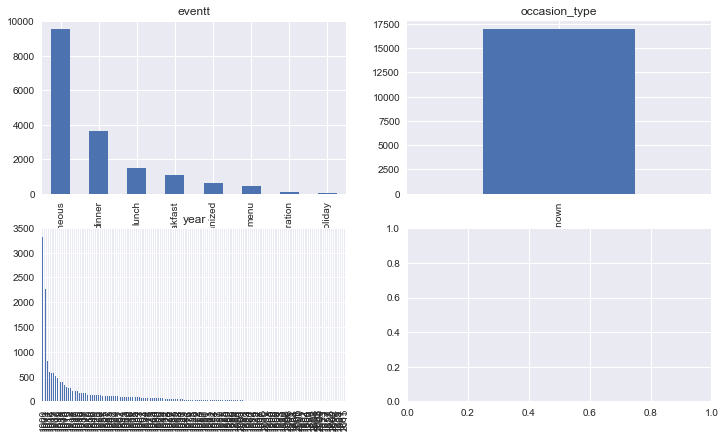

In [812]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
df['eventt'].value_counts().plot(kind='bar', ax=axs[0][0], title='eventt')
df['occasion_type'].value_counts().plot(kind='bar', ax=axs[0][1], title='occasion_type')
df['year'].value_counts().plot(kind='bar', ax=axs[1][0], title='year');

**Linear Regression Fit Attempts - Price**

In [813]:
results = smf.ols(formula="price ~ year", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     50.39
Date:                Thu, 09 Mar 2017   Prob (F-statistic):           1.31e-12
Time:                        16:32:24   Log-Likelihood:                -39679.
No. Observations:               16959   AIC:                         7.936e+04
Df Residuals:                   16957   BIC:                         7.938e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.2609      1.535      7.335      0.000         8.252    14.270
year          -0.0057      0.001     -7.099      0.000        -0.007    -0.004
==============================================================================
Omnibus:                    34115.226   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        103813717.714
Skew:                          16.614   Prob(JB):                         0.00
Kurtosis:                     384.852   Cond. No.                     1.53e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [814]:
results = smf.ols(formula="price ~ dish_count", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.623
Date:                Thu, 09 Mar 2017   Prob (F-statistic):             0.0177
Time:                        16:32:24   Log-Likelihood:                -39701.
No. Observations:               16959   AIC:                         7.941e+04
Df Residuals:                   16957   BIC:                         7.942e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3980      0.024     16.429      0.000         0.350     0.445
dish_count    -0.0005      0.000     -2.371      0.018        -0.001 -8.02e-05
==============================================================================
Omnibus:                    34114.603   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        103680662.908
Skew:                          16.614   Prob(JB):                         0.00
Kurtosis:                     384.605   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [815]:
results = smf.ols(formula="price ~ year + eventt + occasion + status", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3290
Date:                Thu, 09 Mar 2017   Prob (F-statistic):               1.00
Time:                        16:32:25   Log-Likelihood:                -8826.0
No. Observations:                3776   AIC:                         1.831e+04
Df Residuals:                    3448   BIC:                         2.035e+04
Df Model:                         327                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================================
                                                                                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                       4.3209     11.450      0.377      0.706       -18.128    26.770
eventt[T.celebration]                                                                                          -0.2965      0.373     -0.796      0.426        -1.027     0.434
eventt[T.dinner]                                                                                               -0.1399      0.161     -0.870      0.384        -0.455     0.175
eventt[T.holiday]                                                                                               0.3073      0.504      0.610      0.542        -0.680     1.294
eventt[T.lunch]                                                                                                 0.1014      0.183      0.554      0.580        -0.257     0.460
eventt[T.menu]                                                                                                 -0.5576      0.335     -1.666      0.096        -1.214     0.099
eventt[T.miscellaneous]                                                                                        -0.0904      0.235     -0.384      0.701        -0.552     0.371
eventt[T.organized]                                                                                             0.0541      0.207      0.261      0.794        -0.352     0.460
occasion[T.0ther  anniv]                                                                                       -0.0574      2.648     -0.022      0.983        -5.248     5.134
occasion[T.0ther  commemorative]                                                                               -0.2579      2.651     -0.097      0.923        -5.455     4.940
occasion[T.0ther  commercial]                                                                                  -0.0443      2.648     -0.017      0.987        -5.235     5.147
occasion[T.0ther  soc]                                                                                         -0.2426      2.651     -0.092      0.927        -5.440     4.954
occasion[T.10nth reunion]                                                                                      -0.0661      2.648     -0.025      0.980        -5.257     5.125
occasion[T.113 anniversary]                                                                                    -0.0879      2.649     -0.033      0.974        -5.282     5.107
occasion[T.13th anniversary]                                                               

**GLM Attempt - Poisson Distribution for Change of rate of price**

In [816]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [817]:
results = smf.glm('price ~ eventt + occasion_type', 
              data=df, 
              offset=np.log(df.year), 
              family=sm.families.Poisson()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                16959
Model:                            GLM   Df Residuals:                    16951
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -20239.
Date:                Thu, 09 Mar 2017   Deviance:                       35578.
Time:                        16:32:27   Pearson chi2:                 2.81e+05
No. Iterations:                    10                                         
===========================================================================================
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  -7.7453      0.034   -229.763      0.000        -7.811    -7.679
eventt[T.celebration]     -11.5082     23.468     -0.490      0.624       -57.504    34.488
eventt[T.dinner]           -0.6939      0.042    -16.331      0.000        -0.777    -0.611
eventt[T.holiday]           0.8372      0.094      8.910      0.000         0.653     1.021
eventt[T.lunch]            -0.1414      0.045     -3.112      0.002        -0.230    -0.052
eventt[T.menu]             -3.2347      0.269    -12.008      0.000        -3.763    -2.707
eventt[T.miscellaneous]    -1.2039      0.039    -30.529      0.000        -1.281    -1.127
eventt[T.organized]        -1.0807      0.083    -13.057      0.000        -1.243    -0.918
===========================================================================================
"""

**Hypothesis Test**

H0 : M(dinner) > 0.41
HA : M(dinner) <= 0.41    

In [819]:
df[df.eventt=='dinner'].price.mean()

0.41139240506329117

In [820]:
import scipy.stats as stats
sample1 = df[df.eventt=='dinner'].price
sample2 = df[df.eventt=='breakfast'].price
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print(t_stat, p_val)


-3.003212486 0.0027196429181


Reject hypothesis that dinner prices are higher than breakfast prices

** CI for Mean Price **

In [732]:
df.price.mean()
n = len(df)
sem = df.price.std(ddof=1) / n ** 0.5
t_score = stats.t(n - 1).ppf(0.975)
lower_bound = df.price.mean() - t_score * sem
upper_bound = df.price.mean() + t_score * sem

In [733]:
print(lower_bound,upper_bound)

0.3254331927 0.401142666725
